Given code that can extract the contents of the inner rectangles (boxes), we can determine whether the 
contents have changed.

Here, take an image of the previous box and see whether the same contents are still there.  The idea is that 
a name does not only get erased, it may also be replaced.  We hope to find something more robust than the ink
method (exploration-2). 


In [15]:
LIVENOTEBOOK = True
import cv2
cv2.__version__
import extract_blue_grid
get_contents = extract_blue_grid.get_contents



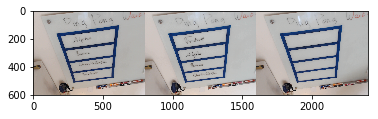

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim 
def imshow(img):  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

imwriting1 = cv2.imread("../reference/frame276.png")
imwriting2 = cv2.imread("../reference/frame280.png")
imempty = cv2.imread("../reference/frame272.png")


if LIVENOTEBOOK:
    %matplotlib inline
    # test plotting
    imshow(np.concatenate([imwriting1,imwriting2,imempty], axis=1))

In [17]:
def threshold_boxes(boxes):
    """Given a list of images, adaptive threshold each image"""
    output = []
    for img in boxes:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dst = cv2.adaptiveThreshold(img, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
        output.append(dst)
    return output


Found 3 outer contours
Found shape with sides: 13
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409
Found 3 outer contours
Found shape with sides: 12
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409
Found 3 outer contours
Found shape with sides: 14
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409


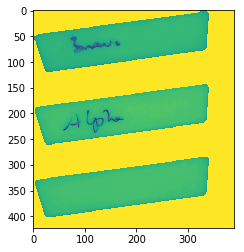

In [40]:
%matplotlib inline
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

writing1 = get_contents("../reference/frame276.png")[1]
writing1 = cv2.morphologyEx(writing1, cv2.MORPH_OPEN, kernel)
img = cv2.cvtColor(writing1, cv2.COLOR_BGR2GRAY)
#writing1 = cv2.adaptiveThreshold(img, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
writing1 = img

writing2 = get_contents("../reference/frame280.png")[1]
img = cv2.cvtColor(writing2, cv2.COLOR_BGR2GRAY)
#writing2 = cv2.adaptiveThreshold(img, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
writing2 = img

empty = get_contents("../reference/frame272.png")[1]
img = cv2.cvtColor(empty, cv2.COLOR_BGR2GRAY)
#empty = cv2.adaptiveThreshold(img, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
empty = img

plt.imshow(np.concatenate([writing1,writing2,empty]))
#plt.imshow(writing1)
#writing1.shape, writing2.shape, empty.shape


Found 4 outer contours
Found shape with sides: 4
-- Rejected rectangle: 2 x 2
Found shape with sides: 15
Found shape with sides: 13
Found shape with sides: 4
-- Found: 445 x 409
Found 3 outer contours
Found shape with sides: 15
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409


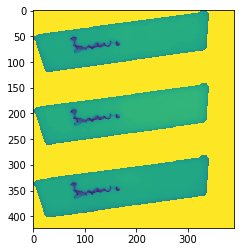

In [41]:
writingb = get_contents("../reference/frame274.png")[1]
writingb = cv2.morphologyEx(writingb, cv2.MORPH_OPEN, kernel)
writingb = cv2.cvtColor(writingb, cv2.COLOR_BGR2GRAY)

writingc = get_contents("../reference/frame275.png")[1]
writingc = cv2.morphologyEx(writingc, cv2.MORPH_OPEN, kernel)
writingc = cv2.cvtColor(writingc, cv2.COLOR_BGR2GRAY)

plt.imshow(np.concatenate([writing1,writingb,writingc]))

(0, 0) (390, 141)


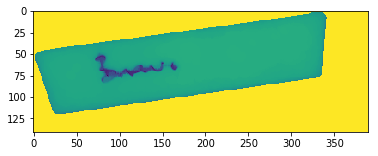

In [50]:
img = writing1.copy()
method = cv2.TM_SQDIFF
w, h = writing1.shape[::-1]
res = cv2.matchTemplate(writingb,writing1,method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = min_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)
print(top_left, bottom_right)
plt.imshow(img)

(0, 0) (390, 141)


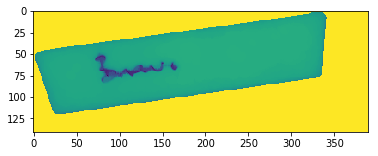

In [51]:
img = writing1.copy()
method = cv2.TM_SQDIFF
w, h = writing1.shape[::-1]
res = cv2.matchTemplate(empty,writing1,method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = min_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)
print(top_left, bottom_right)
plt.imshow(img)

so the first result (2 up ) sounds like the whole img got recognized, great.  but retrying it with empty show we recognize nothing.

i think we should:
- straighten out the image
- take a template just around the word bravo
- then match against a straightened target image
- the straightening may not be nec (may you write crooked) but template matching is on rects.


In [ ]:
########### FIN ####

Found 5 outer contours
Found shape with sides: 13
Found shape with sides: 13
Found shape with sides: 10
Found shape with sides: 4
-- Rejected rectangle: 2 x 9
Found shape with sides: 4
-- Found: 445 x 409


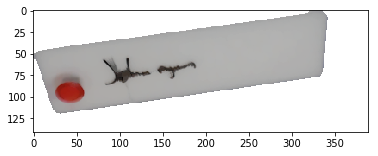

In [70]:
#try something else: first morph then substrction
jr = get_contents("../reference/frame18073.png")[1] 
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
jr = cv2.morphologyEx(jr, cv2.MORPH_OPEN, kernel)
imshow(jr)

Found 5 outer contours
Found shape with sides: 12
Found shape with sides: 17
Found shape with sides: 11
Found shape with sides: 6
Found shape with sides: 4
-- Found: 445 x 409


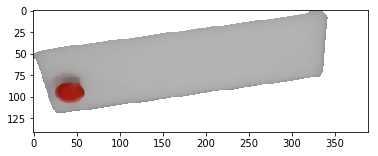

In [71]:
empty = get_contents("../reference/frame18074.png")[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
empty = cv2.morphologyEx(empty, cv2.MORPH_OPEN, kernel)
imshow(empty)

In [73]:
compare_ssim(jr, empty, multichannel=True)


0.95049821074410745

0.436141
(141, 389, 3)


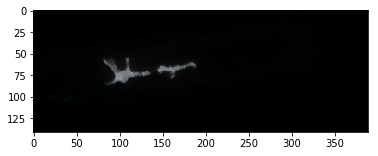

In [122]:
diff = cv2.absdiff(jr, empty)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
diff = cv2.morphologyEx(diff, cv2.MORPH_OPEN, kernel)
print (diff.sum()/1e6)
print(diff.shape)
imshow(diff)

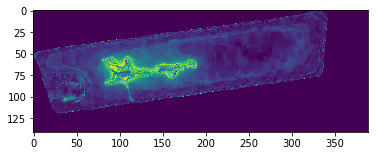

In [92]:

contentmask = np.sqrt(np.sum(diff**2, axis=2))
plt.imshow(contentmask)

Found 6 outer contours
Found shape with sides: 7
Found shape with sides: 16
Found shape with sides: 17
Found shape with sides: 8
Found shape with sides: 7
Found shape with sides: 4
-- Found: 445 x 410


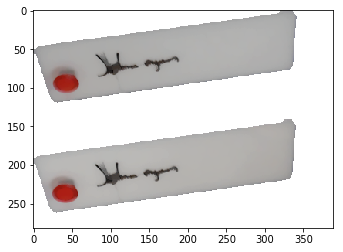

In [107]:
same = get_contents("../reference/frame18059.png")[1] # same only in box1
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
same = cv2.morphologyEx(same, cv2.MORPH_OPEN, kernel)
same = same[:,1:390,:] # crop to size of JR TODO

imshow(np.concatenate([jr, same], axis=0))


0.565449


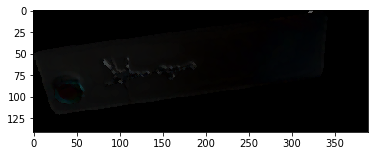

In [121]:

diff2 = cv2.absdiff(jr, same)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
diff2 = cv2.morphologyEx(diff2, cv2.MORPH_OPEN, kernel)
#contentmask2 = np.sqrt(np.sum(diff2**2, axis=2))
#plt.imshow(contentmask2)
print (diff2.sum()/1e6)
imshow(diff2)
#print (same.shape, jr.shape)